In [26]:
%pylab inline
#import matplotlib as plt
#import numpy as np
import pandas as pd
import uncertainties
from uncertainties import unumpy as unp
from uncertainties import ufloat
from sympy import *
from numpy import array as array

def gaussian(x, mu, sigma, B, A):
    return A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)) + B

def gausfit_pm(x, y, p0=None):
    import numpy as np
    return fit_pm(x, y, func=lambda x, mu, sigma, B, A: A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)) + B,
                  p0=p0)
def sine(x,a,b,c,d):
    import numpy as np
    return a*np.sin(c*x-d)+b

def sinefit_pm(x,y,p0=None):
    return fit_pm(x,y,sine,p0=p0)

def line(x,a,b):
    return a * x + b

def linfit_pm(x, y, p0=None):
    return fit_pm(x, y, func=lambda x, a, b,: a * x + b, p0=p0)


def fit_pm(x, y, func=lambda x: x, p0=None):
    """
        fit_pm takes data points and makes an exponential curve fit. It returns
        the parameters with errors and the coefficient of determination
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: Function to be fitted to.
        Returns:
        -----------
        list: Gives back a list with the parameters of an expotential function the
              corresponding errors and the coefficient of determination.
    """
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, x, y, p0=p0)
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    try:
        from uncertainties import unumpy as unp
        return unp.uarray(params, errors), R_2
    except:
        return np.array(params), np.array(errors), R_2


def val(x):
    from uncertainties import unumpy
    try:
        return unumpy.nominal_values(x)
    except TypeError:
        return x


def errr(x):
    from uncertainties import unumpy
    return unumpy.std_devs(x)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size


Populating the interactive namespace from numpy and matplotlib


c:\users\erik_\appdata\local\programs\python\python37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['partition', 'var', 'log', 'det', 'diag', 'sqrt', 'gamma', 'reshape', 'cosh', 'product', 'cos', 'solve', 'conjugate', 'nan', 'Circle', 'trace', 'zeros', 'invert', 'interactive', 'transpose', 'lcm', 'prod', 'Line2D', 'deprecated', 'sign', 'poly', 'gcd', 'mod', 'plot', 'tan', 'fft', 'binomial', 'tanh', 'ones', 'sin', 'plotting', 'pi', 'vectorize', 'power', 'diff', 're', 'sinh', 'ifft', 'add', 'Number', 'flatten', 'test', 'seterr', 'multinomial', 'trunc', 'eye', 'axes', 'floor', 'exp', 'take', 'roots', 'Polygon', 'sinc', 'source', 'beta', 'cbrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
%store -r cali
%store -r upper_bound
%store -r lower_bound
print("cali\n",cali)
print("bounds")
print(upper_bound,lower_bound)

cali
 [0.00044244234308799294+/-1.985696919947778e-05
 0.003736509102934345+/-0.005445659683568066]
bounds
0.04733+/-0.00015 -0.01105+/-0.00015


In [3]:
#filenames = ["dx_1.csv","dx_2.csv","dx_3.csv","dx_4.csv","dx_5.csv"]
filename_l,filename_r = "guess_f",".csv"
#data = [[a_ch1,a_ch2],[b_ch1,b_ch2],[c_ch1,c_ch2],[d_ch1,d_ch2],[e_ch1,e_ch2]]
data= []
for i in [1,2,3,4,5,6]:
    df = pd.read_csv(filename_l+str(i)+filename_r,index_col=0)
    print("file read",i)
    ch1 = [float(item)for item in df.iloc[1:,0].to_numpy()]
    ch2 = [float(item)for item in df.iloc[1:,1].to_numpy()]
    data.append([array(ch1),array(ch2)])

file read 1
file read 2
file read 3
file read 4
file read 5
file read 6


In [4]:
def analysis(data_sine, data_dip, dist_to_dip=20, printt=0, plott=0,save=0):  
    x = np.arange(len(data_sine))
    if plott:
        plt.plot(x,data_sine,label=0)
        plt.plot(x,data_dip,label=1)
        plt.legend()
        plt.show()

    def siner(x,y):
        guess = [max(y),mean(y),100**-1,1]
        params,errs = sinefit_pm(x,y,p0=guess)
        return params,errs

    def nuller(x,y,prec=0.01):
        iterator = 0
        nullstellen = [[],[]]
        last = 0
        for item in y:
            if abs(item)<=prec:
                if not abs(x[iterator]-last)<=5:
                    nullstellen[0].append(x[iterator])
                    nullstellen[1].append(y[iterator])
                last=x[iterator]
            iterator += 1

        return nullstellen

    def to_freq(x):
        return line(x,*cali)
    
    x = np.arange(len(data_sine))
    x_fine = np.linspace(0,len(data_sine),8*len(data_sine))
    y = data_dip
    params,err = siner(x,y)

    y_guess = val(sine(x_fine,*val(params)))

    nullstellen = nuller(x_fine,y_guess)
    if plott:
        plt.title("nullstellen")
        plt.plot(x,data_dip,label=1)
        plt.plot(x_fine,sine(x_fine,*val(params)))
        plt.plot(*nullstellen,"o")
        plt.show()

    if printt:
        print([int((item)) for item in nullstellen[0]])

    ranges=[] 
    for item in nullstellen[0]:
        datapoints = data_sine[int(item)-dist_to_dip:int(item)+dist_to_dip]
        #print(item)
        #print(datapoints)
        ranges.append([x[int(item)-dist_to_dip:int(item)+dist_to_dip],datapoints])
    #print("\nranges\n\n",ranges)

    if False:
        for i in range(len(ranges)):
            plt.plot(*ranges[i],"-")
            plt.plot(ranges[i][0],np.ones(len(ranges[i][0]))*val(lower_bound),"-")
            plt.show()

    discr = []
    for dataset in ranges:
        intern = []
        for i in range(len(dataset[1])):
            if dataset[1][i] < lower_bound:
                intern.append(i)
        #print(intern)
        stop = 0
        for i in range(len(intern)):
            if i > 1:
                if abs(intern[i]-intern[i-1]) > 2:
                    stop = i
                    break
        intern = intern[:stop]
        output = [[],[]]
        for num in intern:
            output[0].append(dataset[0][num])
            output[1].append(dataset[1][num])
        discr.append(output)
        if False:
            print("output",output)
    if printt:
        print("discr",discr)

    if plott:
        for i in range(len(nullstellen[0])):
            plt.title("Values below threshold")
            plt.plot(*ranges[i],"-")
            plt.plot(ranges[i][0],np.ones(len(ranges[i][0]))*val(lower_bound),"-")
            plt.plot(discr[i][0],discr[i][1],"x")
            plt.show()

    dips = []
    for item in discr:
        dip_y = min(item[1])
        dip_x = item[0][item[1].index(dip_y)]
        dip_err = abs(item[0][0]-item[0][-1])
        combi = ufloat(dip_x,dip_err)
        dips.append(combi)

    nst = nullstellen[0]
    diffs = []
    for i in range(len(nst)):
        intern = dips[i]-nst[i]
        diffs.append(intern)
    freq_unterschied = mean(diffs)
    if printt:
        print("freq_unterschied",freq_unterschied)

    end_freq = to_freq(dips[0]-freq_unterschied)
    return end_freq

In [5]:
def analysis(data_sine, data_dip, dist_to_dip=20, printt=0, plott=0,save=0):  
    x = np.arange(len(data_sine))
    if plott:
        plt.plot(x,data_sine,label=0)
        plt.plot(x,data_dip,label=1)
        plt.legend()
        plt.show()

    def siner(x,y):
        guess = [max(y),mean(y),100**-1,1]
        params,errs = sinefit_pm(x,y,p0=guess)
        return params,errs

    def nuller(x,y,prec=0.01):
        iterator = 0
        nullstellen = [[],[]]
        last = 0
        for item in y:
            if abs(item)<=prec:
                if not abs(x[iterator]-last)<=5:
                    nullstellen[0].append(x[iterator])
                    nullstellen[1].append(y[iterator])
                last=x[iterator]
            iterator += 1

        return nullstellen

    def to_freq(x):
        return line(x,*cali)
    
    x = np.arange(len(data_sine))
    x_fine = np.linspace(0,len(data_sine),8*len(data_sine))
    y = data_dip
    params,err = siner(x,y)

    y_guess = val(sine(x_fine,*val(params)))

    nullstellen = nuller(x_fine,y_guess)
    if plott:
        plt.title("nullstellen")
        plt.plot(x,data_dip,label=1)
        plt.plot(x_fine,sine(x_fine,*val(params)))
        plt.plot(*nullstellen,"o")
        plt.show()

    if printt:
        print([int((item)) for item in nullstellen[0]])

    ranges=[] 
    for item in nullstellen[0]:
        datapoints = data_sine[int(item)-dist_to_dip:int(item)+dist_to_dip]
        #print(item)
        #print(datapoints)
        ranges.append([x[int(item)-dist_to_dip:int(item)+dist_to_dip],datapoints])
    #print("\nranges\n\n",ranges)

    if False:
        for i in range(len(ranges)):
            plt.plot(*ranges[i],"-")
            plt.plot(ranges[i][0],np.ones(len(ranges[i][0]))*val(lower_bound),"-")
            plt.show()

    discr = []
    for dataset in ranges:
        intern = []
        for i in range(len(dataset[1])):
            if dataset[1][i] < lower_bound:
                intern.append(i)
        #print(intern)
        stop = 0
        for i in range(len(intern)):
            if i > 1:
                if abs(intern[i]-intern[i-1]) > 2:
                    stop = i
                    break
        intern = intern[:stop]
        output = [[],[]]
        for num in intern:
            output[0].append(dataset[0][num])
            output[1].append(dataset[1][num])
        discr.append(output)
        if False:
            print("output",output)
    if printt:
        print("discr",discr)

    if plott:
        for i in range(len(nullstellen[0])):
            plt.title("Values below threshold")
            plt.plot(*ranges[i],"-")
            plt.plot(ranges[i][0],np.ones(len(ranges[i][0]))*val(lower_bound),"-")
            plt.plot(discr[i][0],discr[i][1],"x")
            plt.show()

    dips = []
    for item in discr:
        dip_y = min(item[1])
        dip_x = item[0][item[1].index(dip_y)]
        dip_err = abs(item[0][0]-item[0][-1])
        combi = ufloat(dip_x,dip_err)
        dips.append(combi)

    nst = nullstellen[0]
    diffs = []
    for i in range(len(nst)):
        intern = dips[i]-nst[i]
        diffs.append(intern)
    freq_unterschied = mean(diffs)
    if printt:
        print("freq_unterschied",freq_unterschied)

    end_freq = to_freq(freq_unterschied)
    return end_freq

In [6]:
# 2. nullstelle manuell machen
#analysis(*data[3],20,plott=1)

data_sine, data_dip =data[3][0],data[3][1]
dist_to_dip=20
printt=0
plott=0
  
x = np.arange(len(data_sine))
if plott:
    plt.plot(x,data_sine,label=0)
    plt.plot(x,data_dip,label=1)
    plt.legend()
    plt.show()

def siner(x,y):
    guess = [max(y),mean(y),100**-1,1]
    params,errs = sinefit_pm(x,y,p0=guess)
    return params,errs

def nuller(x,y,prec=0.01):
    iterator = 0
    nullstellen = [[],[]]
    last = 0
    for item in y:
        if abs(item)<=prec:
            if not abs(x[iterator]-last)<=5:
                nullstellen[0].append(x[iterator])
                nullstellen[1].append(y[iterator])
            last=x[iterator]
        iterator += 1

    return nullstellen

def to_freq(x):
    return line(x,*cali)

x = np.arange(len(data_sine))
x_fine = np.linspace(0,len(data_sine),8*len(data_sine))
y = data_dip
params,err = siner(x,y)

y_guess = val(sine(x_fine,*val(params)))

nullstellen = nuller(x_fine,y_guess)
if plott:
    plt.title("nullstellen")
    plt.plot(x,data_dip,label=1)
    plt.plot(x_fine,sine(x_fine,*val(params)))
    plt.plot(*nullstellen,"o")
    plt.show()

if printt:
    print([int((item)) for item in nullstellen[0]])

ranges=[] 
for item in nullstellen[0]:
    datapoints = data_sine[int(item)-dist_to_dip:int(item)+dist_to_dip]
    #print(item)
    #print(datapoints)
    ranges.append([x[int(item)-dist_to_dip:int(item)+dist_to_dip],datapoints])
#print("\nranges\n\n",ranges)

if False:
    for i in range(len(ranges)):
        plt.plot(*ranges[i],"-")
        plt.plot(ranges[i][0],np.ones(len(ranges[i][0]))*val(lower_bound),"-")
        plt.show()

discr = []
for dataset in ranges:
    intern = []
    for i in range(len(dataset[1])):
        if dataset[1][i] < lower_bound:
            intern.append(i)
    #print(intern)
    stop = 0
    for i in range(len(intern)):
        if i > 1:
            if abs(intern[i]-intern[i-1]) > 2:
                stop = i
                break
    intern = intern[:stop]
    output = [[],[]]
    for num in intern:
        output[0].append(dataset[0][num])
        output[1].append(dataset[1][num])
    discr.append(output)
    if False:
        print("output",output)
if printt:
    print("discr",discr)

discr[1]=[ranges[1][0][15:21],ranges[1][1][15:21]]
if plott:
    for i in range(len(nullstellen[0])):
        plt.title("Values below threshold")
        plt.plot(*ranges[i],"-")
        plt.plot(ranges[i][0],np.ones(len(ranges[i][0]))*val(lower_bound),"-")
        plt.plot(discr[i][0],discr[i][1],"x")
        plt.show()

dips = []
for item in discr:
    dip_y = min(item[1])
    dip_x = item[0][list(item[1]).index(dip_y)]
    dip_err = abs(item[0][0]-item[0][-1])
    combi = ufloat(dip_x,dip_err)
    dips.append(combi)

nst = nullstellen[0]
diffs = []
for i in range(len(nst)):
    intern = dips[i]-nst[i]
    diffs.append(intern)
freq_unterschied = mean(diffs)
if printt:
    print("freq_unterschied",freq_unterschied)

end_freq = to_freq(freq_unterschied)
end_freq

-3.31389924807567e-05+/-0.005564810561974581

In [7]:
frequs=(analysis(*data[0],20),analysis(*data[1],20),analysis(*data[2],20),end_freq,analysis(*data[4]),analysis(*data[5]))

In [8]:
magnets = unp.uarray([461,503,474,436,447,466],1)

In [9]:
def LRmG(x: list , y: list, u: list) -> list:
    """Linear Regression, weighted.
    
    """
    try:
        u[0]
        if (len(x) != len(y)):
            raise LenError
        if (len(x) != len(u)):
            raise LenError
        x = array(x)
        y = array(y)
        u = array(u)
        g = []
        for i in range(len(y)):
            g.append(1 / u[i] ** 2)

        a = (sum(g * (x ** 2)) * sum(g * y) - sum(g * x) * sum(g * x * y)) / (
                    sum(g) * sum(g * (x ** 2)) - (sum(g * x) ** 2))

        b = (sum(g) * sum(g * x * y) - sum(g * x) * sum(g * y)) / (sum(g) * sum(g * x ** 2) - sum(g * x) ** 2)

        ua = sqrt(sum(g * x ** 2) / (sum(g) * sum(g * x ** 2) - sum(g * x) ** 2))

        ub = sqrt(sum(g) / (sum(g) * sum(g * x ** 2) - sum(g * x) ** 2))

        return a, b, ua, ub

    except TypeError:
        return LRmG(x, y, ones(len(y)) * u)

In [10]:
true_freqs= array(frequs)+unp.uarray([19.0948,19.4937,18.5235,17.9994,17.5470,18.0218],0.00005)

In [11]:
a,b,ua,ub = LRmG(val(magnets),val(true_freqs),errr(true_freqs))
params,err = linfit_pm(val(magnets),val(true_freqs))

In [12]:
print(params)
print(b,a)

[0.024647148384668416+/-0.009954898405305541
 6.9990957459095355+/-4.628879669548782]
0.02464855602699656 6.999371043726408


In [13]:
line(1000,*params)

31.64624413057795+/-10.978457508007072

In [14]:
params

array([0.024647148384668416+/-0.009954898405305541,
       6.9990957459095355+/-4.628879669548782], dtype=object)

In [15]:
hbar =  1.054571817e-34 # J S
%store hbar

Stored 'hbar' (float)


In [50]:
gamma=params[0]*2*np.pi
gamma2=((true_freqs*1e6)/(magnets*1e-3))*2*np.pi
mu_k = gamma*hbar/2
mu_k_2 = gamma2*hbar/2

In [51]:
gamma

0.15486260059442367+/-0.06254847139468127

In [52]:
mu_k

8.165686704710332e-36+/-3.2980927564630774e-36

In [55]:
gamma2

array([260274403.11011666+/-569541.9200858511,
       243527800.16964516+/-488973.51296237466,
       245552360.48600754+/-523149.98896837176,
       259388434.40279263+/-600308.6740666952,
       246663027.7460017+/-557332.9567002022,
       242998343.8354773+/-526705.2309603016], dtype=object)

In [56]:
mu_k_2

array([1.3723902510321308e-26+/-3.0031142876130237e-29,
       1.284087773574578e-26+/-2.578288430148022e-29,
       1.29476299483184e-26+/-2.758496172149529e-29,
       1.3677186628846915e-26+/-3.1653430458568777e-29,
       1.300619386784112e-26+/-2.938738144106573e-29,
       1.2812960249328502e-26+/-2.777242462186049e-29], dtype=object)

In [57]:
df = pd.DataFrame(np.transpose([true_freqs,magnets,gamma2,mu_k_2]),
                  columns=["Corrected resonance frequencies","Measured magnetic fields",r"$\gamma$",r"$\mu_K$"])

In [58]:
df

,Corrected resonance frequencies,Measured magnetic fields,$\gamma$,$\mu_K$
0,19.096+/-0.006,461.0+/-1.0,(2.603+/-0.006)e+08,(1.3724+/-0.0030)e-26
1,19.496+/-0.005,503.0+/-1.0,(2.435+/-0.005)e+08,(1.2841+/-0.0026)e-26
2,18.524+/-0.006,474.0+/-1.0,(2.456+/-0.005)e+08,(1.2948+/-0.0028)e-26
3,17.999+/-0.006,436.0+/-1.0,(2.594+/-0.006)e+08,(1.3677+/-0.0032)e-26
4,17.548+/-0.006,447.0+/-1.0,(2.467+/-0.006)e+08,(1.3006+/-0.0029)e-26
5,18.022+/-0.006,466.0+/-1.0,(2.430+/-0.005)e+08,(1.2813+/-0.0028)e-26


In [59]:
print(df.to_latex())

\begin{tabular}{lllll}
\toprule
{} & Corrected resonance frequencies & Measured magnetic fields &             \$\textbackslash gamma\$ &                \$\textbackslash mu\_K\$ \\
\midrule
0 &                  19.096+/-0.006 &              461.0+/-1.0 &  (2.603+/-0.006)e+08 &  (1.3724+/-0.0030)e-26 \\
1 &                  19.496+/-0.005 &              503.0+/-1.0 &  (2.435+/-0.005)e+08 &  (1.2841+/-0.0026)e-26 \\
2 &                  18.524+/-0.006 &              474.0+/-1.0 &  (2.456+/-0.005)e+08 &  (1.2948+/-0.0028)e-26 \\
3 &                  17.999+/-0.006 &              436.0+/-1.0 &  (2.594+/-0.006)e+08 &  (1.3677+/-0.0032)e-26 \\
4 &                  17.548+/-0.006 &              447.0+/-1.0 &  (2.467+/-0.006)e+08 &  (1.3006+/-0.0029)e-26 \\
5 &                  18.022+/-0.006 &              466.0+/-1.0 &  (2.430+/-0.005)e+08 &  (1.2813+/-0.0028)e-26 \\
\bottomrule
\end{tabular}



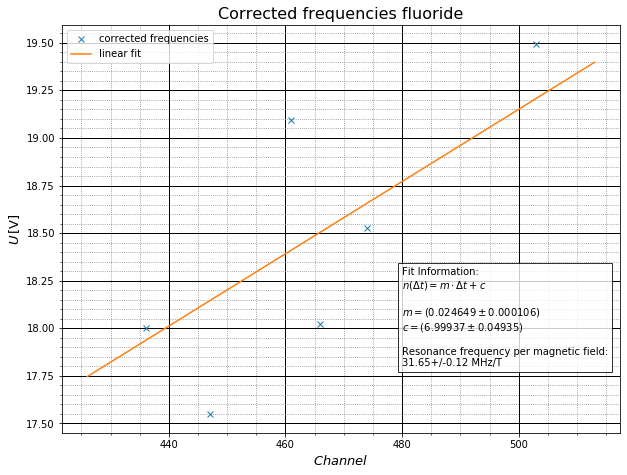

In [60]:
plt.plot(val(magnets), val(true_freqs),"x",label="corrected frequencies")

plt.plot(np.linspace(min(val(magnets))-10,max(val(magnets))+10),line(np.linspace(min(val(magnets)),max(val(magnets))),b,a),label="linear fit")
plt.text(480,17.8,'Fit Information:\n$n(\\Delta t)=m\\cdot \\Delta t +c $\n\n$m=({:.6f}\\pm {:.6f})$\n$c=({:.5f}\\pm {:.5f})$\n\nResonance frequency per magnetic field:\n{:} MHz/T'
         .format(b,ub,a,ua,line(1000,ufloat(b,ub),ufloat(a,ua))),bbox={'facecolor':'white', 'alpha':0.8}, fontsize=10)
#"Resonance frequency per magnetic field:\n{:} \\frac{MHz}{T}".format(line(1000,ufloat(b,ub),ufloat(a,ua))), 

###   Label / Title

plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
plt.xlabel(r'$Channel$', fontsize=13)
plt.title('Corrected frequencies fluoride', fontsize=16)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

#axes.set_xlim([0,0.8])
#axes.set_ylim([-1,110])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend()
plt.savefig('flouride.png')
plt.show()

In [103]:
lit = 1.328e-26

In [101]:
def vertrag(x, ux, y):
    """determines, whether your value is compatible with a given value"""
    return np.abs(x - y) / ux


def vergl(x, ux, y, uy):
    """determines, whether two values are compativle"""
    return abs(x - y) / sqrt(ux ** 2 + uy ** 2)


In [109]:
comps = []
vals = val(mu_k_2)
errrs = errr(mu_k_2)
for i in range(len(mu_k_2)):
    comps.append(vertrag(vals[i],errrs[i],lit))

In [110]:
df2 = pd.DataFrame((comps),columns=["compatibility"])

In [112]:
print(df2.to_latex())

\begin{tabular}{lr}
\toprule
{} &  compatibility \\
\midrule
0 &      14.781406 \\
1 &      17.031542 \\
2 &      12.048958 \\
3 &      12.547981 \\
4 &       9.317133 \\
5 &      16.816672 \\
\bottomrule
\end{tabular}

